# 1.1 Introduction to Regression

The goal of regression analysis is to provide accurate mapping from one or
more input variables (called features in machine learning or exogenous
variables in econometrics) to a continuous output variable (called the label or
target in machine learning and the endogenous variable in
econometrics).

In this lecture, we will study some of the most fundamental and widely-used
regression algorithms.

We will follow this same general pattern when we learn each algorithm:

- Describe the mathematical foundation for the algorithm  
- Use the [scikit-learn](https://scikit-learn.org/stable/) python package to
  apply the algorithm to a real world dataset on house prices in Washington state  

### Dataset

Let’s load the dataset and take a quick look at our task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']

# We will import all these here to ensure that they are loaded, but
# will usually re-import close to where they are used to make clear
# where the functions come from
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

url = "https://datascience.quantecon.org/assets/data/kc_house_data.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

This dataset contains sales prices on houses in King County (which
includes Seattle),
Washington, from May 2014 to May 2015.

The data comes from
[Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) . Variable definitions and additional documentation are available at that link.

In [2]:
X = df.drop(["price", "date", "id"], axis=1).copy()
# convert everything to be a float for later on
for col in list(X):
    X[col] = X[col].astype(float)
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


In [3]:
# notice the log here!
y = np.log(df["price"])
df["log_price"] = y
y.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: price, dtype: float64

While we will be using all variables in `X` in our regression models,
we will explain some algorithms that use only the `sqft_living` variable.

Here’s what the log house price looks like against `sqft_living`:

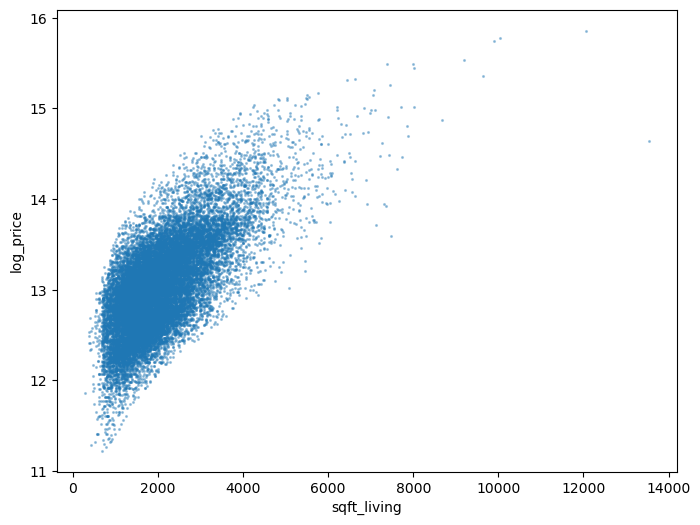

In [4]:
def var_scatter(df, ax=None, var="sqft_living"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y="log_price", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(df);

# Linear Regression

Let’s dive in by studying the [“Hello World”](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of regression
algorithms: linear regression.

Suppose we would like to predict the log of the sale price of a home, given
only the livable square footage of the home.

The linear regression model for this situation is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} + \epsilon
$$

$ \beta_0 $ and $ \beta_1 $ are called parameters (also coefficients or
weights). The machine learning algorithm is tasked with finding the parameter values
that best fit the data.

$ \epsilon $ is the error term. It would be unusual for the observed
$ \log(\text{price}) $ to be an exact linear function of
$ \text{sqft_living} $. The error term captures the deviation of
$ \log(\text{price}) $ from a linear function of $ \text{sqft_living} $.

The linear regression algorithm will choose the parameters that minimize the
*mean squared error* (MSE) function, which for our example is written.

$$
\frac{1}{N} \sum_{i=1}^N \left(\log(\text{price}_i) - (\beta_0 + \beta_1 \text{sqft_living}_i) \right)^2
$$

The output of this algorithm is the straight line (hence linear) that passes as
close to the points on our scatter chart as possible.

The `sns.lmplot` function below will plot our scatter chart and draw the
optimal linear regression line through the data.

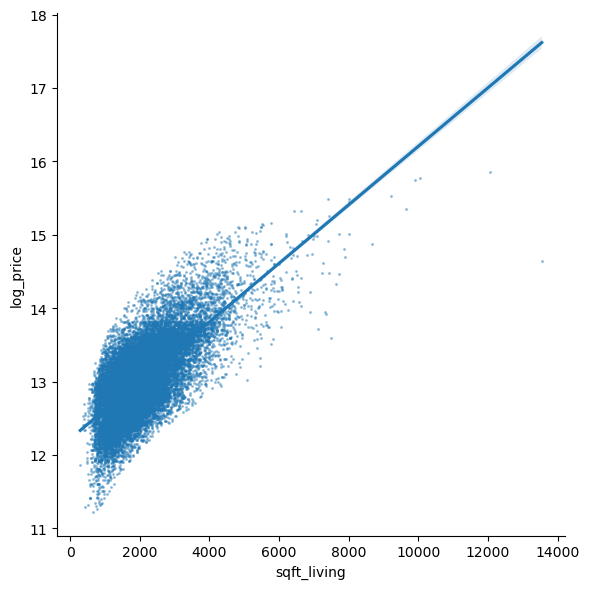

In [5]:
sns.lmplot(
    data=df, x="sqft_living", y="log_price", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
);

Let’s use `sklearn` to replicate the figure ourselves.

First, we fit the model.

In [6]:
# import
from sklearn import linear_model

# construct the model instance
sqft_lr_model = linear_model.LinearRegression()

# fit the model
sqft_lr_model.fit(X[["sqft_living"]], y)

# print the coefficients
beta_0 = sqft_lr_model.intercept_
beta_1 = sqft_lr_model.coef_[0]

print(f"Fit model: log(price) = {beta_0:.4f} + {beta_1:.4f} sqft_living")

Fit model: log(price) = 12.2185 + 0.0004 sqft_living


Then, we construct the plot.

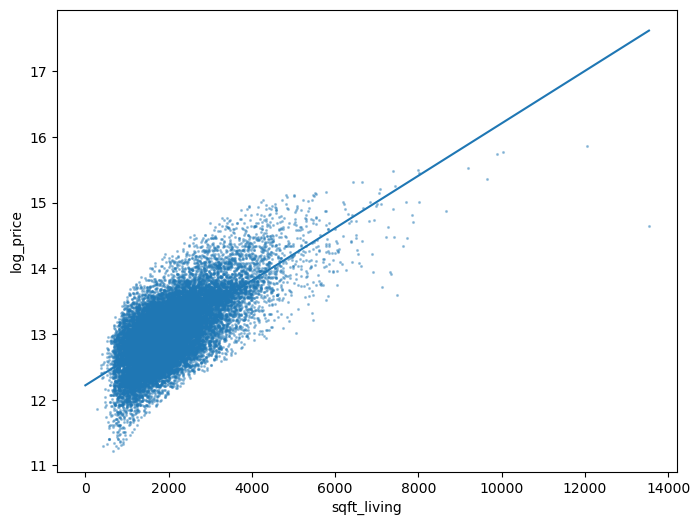

In [7]:
ax = var_scatter(df)

# points for the line
x = np.array([0, df["sqft_living"].max()])
ax.plot(x, beta_0 + beta_1*x)

We can call the `predict` method on our model to evaluate the model at
arbitrary points.

For example, we can ask the model to predict the sale price of a 5,000-square-foot home.

In [8]:
# Note, the argument needs to be two-dimensional. You'll see why shortly.
logp_5000 = sqft_lr_model.predict([[5000]])[0]
print(f"The model predicts a 5,000 sq. foot home would cost {np.exp(logp_5000):.2f} dollars")

The model predicts a 5,000 sq. foot home would cost 1486889.32 dollars


C:\Users\Miguel\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Exercise 1

Use the `sqft_lr_model` that we fit to generate predictions for all data points
in our sample.

Note that you need to pass a DataFrame (not Series)
containing the `sqft_living` column to the `predict`. (See how we passed that to `.fit`
above for help)

Make a scatter chart with the actual data and the predictions on the same
figure. Does it look familiar?

When making the scatter for model predictions, we recommend passing
`c="red"` and `alpha=0.25` so you can distinguish the data from
predictions.

### Exercise 2

Use the `metrics.mean_squared_error` function to evaluate the loss
function used by `sklearn` when it fits the model for us.

Read the docstring to learn which the arguments that function takes.

In [9]:
from sklearn import metrics

# Multivariate Linear Regression

Our example regression above is called a univariate linear
regression since it uses a single feature.

In practice, more features would be used.

Suppose that in addition to `sqft_living`, we also wanted to use the `bathrooms` variable.

In this case, the linear regression model is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} +
\beta_2 \text{bathrooms} + \epsilon
$$

We could keep adding one variable at a time, along with a new $ \beta_{j} $ coefficient for the :math:`j`th variable, but there’s an easier way.

Let’s write this equation in vector/matrix form as

$$
\underbrace{\begin{bmatrix} \log(\text{price}_1) \\ \log(\text{price}_2) \\ \vdots \\ \log(\text{price}_N)\end{bmatrix}}_Y = \underbrace{\begin{bmatrix} 1 & \text{sqft_living}_1 & \text{bathrooms}_1 \\ 1 & \text{sqft_living}_2 & \text{bathrooms}_2 \\ \vdots & \vdots & \vdots \\ 1 & \text{sqft_living}_N & \text{bathrooms}_N \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{bmatrix}}_{\beta} + \epsilon
$$

Notice that we can add as many columns to $ X $ as we’d like and the linear
regression model will still be written $ Y = X \beta + \epsilon $.

The mean squared error loss function for the general model is

$$
\frac{1}{N} \sum_{i=1}^N (y_i - X_i \beta)^2 = \frac{1}{N} \| y - X \beta\|_2^2
$$

where $ || \cdot ||_2 $ is the [l2-norm](http://mathworld.wolfram.com/L2-Norm.html).

Let’s fit the linear regression model using all columns in `X`.

In [10]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

LinearRegression()

We just fit a model with 18 variables – just as quickly and easily as
fitting the model with 1 variable!

Visualizing a 18-dimensional model is rather difficult, but just so we can see how the
extra features changed our model, let’s make the log price vs `sqft_living`
one more time – this time including the prediction from both of our linear models.

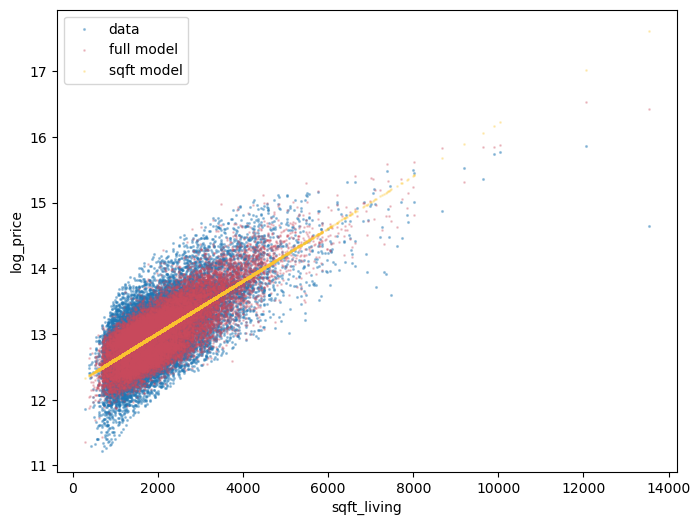

In [11]:
ax = var_scatter(df)

def scatter_model(mod, X, ax=None, color=colors[1], x="sqft_living"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1)
    return ax

scatter_model(lr_model, X, ax, color=colors[1])
scatter_model(sqft_lr_model, X[["sqft_living"]], ax, color=colors[2])
ax.legend(["data", "full model", "sqft model"])

### Exercise

See exercise 3 in the [exercise list](#app-reg-ex).

# Nonlinear Relationships in Linear Regression

While it sounds like an oxymoron, a linear regression model can actually include non-linear features.

The distinguishing feature of the linear regression model is that each
prediction is generated by taking the dot product (a linear operator) between a
feature vector (one row of $ X $) and a coefficient vector ($ \beta $).

There is, however, no restriction on what element we include in our feature
vector.

Let’s consider an example…

Starting from the `sqft_living`-only model, suppose we have a hunch that we
should also include the *fraction of square feet above ground*.

This last variable can be computed as `sqft_above / sqft_living`.

This second feature is nonlinear, but could easily be included as a column in
`X`.

Let’s see this in action.

In [12]:
X2 = X[["sqft_living"]].copy()
X2["pct_sqft_above"] = X["sqft_above"] / X["sqft_living"]

sqft_above_lr_model = linear_model.LinearRegression()
sqft_above_lr_model.fit(X2, y)

new_mse = metrics.mean_squared_error(y, sqft_above_lr_model.predict(X2))
old_mse = metrics.mean_squared_error(y, sqft_lr_model.predict(X2[["sqft_living"]]))
print(f"The mse changed from {old_mse:.4f} to {new_mse:.4f} by including our new feature")

The mse changed from 0.1433 to 0.1430 by including our new feature


### Exercise

See exercise 4 in the [exercise list](#app-reg-ex).

Determining which columns belong in $ X $ is called *feature
engineering* and is a large part of a machine learning practitioner’s job.

You may recall from (or will see in) your econometrics course(s) that
choosing which control variables to include in a regression model
is an important part of applied research.

### Interpretability

Before moving to our next regression model, we want to broach the idea of
the **interpretability** of models.

An interpretable model is one for which we can analyze the
coefficients to explain why it makes its predictions.

Recall $ \beta_0 $ and $ \beta_1 $ from the univariate model.

The interpretation of the model is that $ \beta_0 $ captures the notion of
the average or starting house price and $ \beta_1 $ is the additional value
per square foot.

Concretely, we have

In [13]:
beta_0, beta_1

(12.218464096380853, 0.0003987465387451508)

which means that our model predicts the log price of a house to be 12.22, plus
an additional 0.0004 for every square foot.

Using more exotic machine learning methods might potentially be more accurate but
less interpretable.

The accuracy vs interpretability tradeoff is a hot discussion topic, especially relating
to concepts like machine learning ethics. This is something you
should be aware of as you continue to learn about these techniques.

## References

Some good text books covering the above regression methods:

<a id='id27'></a>
\[regB06\] Christopher M. Bishop. *Pattern Recognition and Machine Learning*. Springer, 2006. URL: [https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

<a id='id27'></a>
\[regEH16\] Bradley Efron and Trevor Hastie. *Computer age statistical inference*. Volume 5. Cambridge University Press, 2016. URL: [https://web.stanford.edu/~hastie/CASI/](https://web.stanford.edu/~hastie/CASI/).

<a id='id26'></a>
\[regFHT09\] Jerome Friedman, Trevor Hastie, and Robert Tibshirani. *The elements of statistical learning*. Springer series in statistics, 2009. URL: [https://web.stanford.edu/~hastie/ElemStatLearn/](https://web.stanford.edu/~hastie/ElemStatLearn/).


<a id='app-reg-ex'></a>

# Exercises

### Exercise 1

Use the `sqft_lr_model` that we fit to generate predictions for all data points
in our sample.

Note that you need to pass a DataFrame (not Series)
containing the `sqft_living` column to the `predict`. (See how we passed that to `.fit`
above for help)

Make a scatter chart with the actual data and the predictions on the same
figure. Does it look familiar?

When making the scatter for model predictions, we recommend passing
`c="red"` and `alpha=0.25` so you can distinguish the data from
predictions.

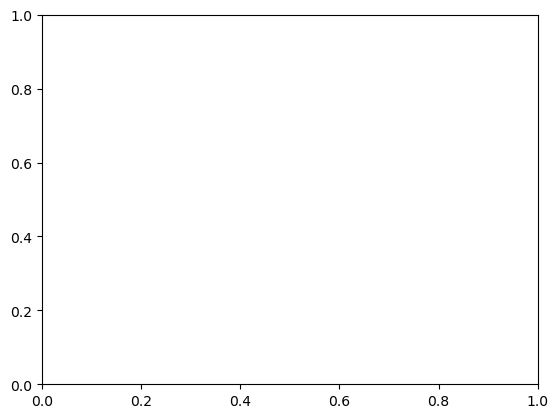

In [14]:
# Generate predictions

# Plot
fig, ax = plt.subplots()

# Make scatter of data

# Make scatter of predictions

([back to text](#app-reg-dir1))

### Exercise 2

Use the `metrics.mean_squared_error` function to evaluate the loss
function used by `sklearn` when it fits the model for us.

Read the docstring to learn which the arguments that function takes.

In [15]:
from sklearn import metrics

# your code here

([back to text](#app-reg-dir2))

### Exercise 3

Compare the mean squared error for the `lr_model` and the `sqft_lr_model`.

Which model has a better fit? Defend your choice.

([back to text](#app-reg-dir3))

### Exercise 4

Explore how you can improve the fit of the full model by adding additional
features created from the existing ones.

In [16]:
# your code here

([back to text](#app-reg-dir4))